---
title: "ERA5 hourly data on single levels from 1940 to present"
subtitle: "This notebook shows how to authenticate with the DestinE API, queries and downloads ERA5 single-level reanalysis data using the DEDL HDA service, and visualizes the result with EarthKit."
author: "Michael Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)"
tags: [HDA, STAC, ECMWF]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/CDS_data/DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b><ul>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li></ul>
<b> References: </b><ul>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview">ERA5 data documentation</a></li></ul>
<b> Credit: </b><ul>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li></ul>
</div>

This notebook demonstrates how to use the HDA (Harmonized Data Access) API to access ERA5 hourly data on single levels, and how to visualize the data using the Earthkit package provided by ECMWF.

The method used to access this dataset can be applied to all the datasets hosted by the climate data store provided through HDA. 
The complete list of the climate data store federated datasets provided by HDA:  https://hda.data.destination-earth.eu/stac/collections?provider=cop_cds.

Below the main steps covered by this tutorial.

1. [Authenticate](#DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-Authenticate): How to authenticate for searching and access *DEDL* collections. 
2. [Order data](#DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-Order):  How to order ERA5 hourly data on single levels data through HDA.
3. [Download data](#DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-Download): How to download hourly data on single levels data through HDA.
4. [Visualize](#DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-EarthKit): How to visualize hourly data on single levels data through Earthkit.

(DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-Authenticate)=
# Authenticate

First we import the required packages

In [2]:
import requests
import json
import os
import json
from getpass import getpass
from IPython.display import JSON
import destinelab as deauth
from tqdm import tqdm
import time
from urllib.parse import unquote
from time import sleep

We get an access token for the API

In [3]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


Response code: 200
DEDL/DESP Access Token Obtained Successfully


(DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-Order)=
# Order


Climate data store datasets need to be ordered.
Below the steps to order the data of our interest.

## HDA endpoint
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC), it is convenient define a costant with its endpoint.

In [4]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"

## Collection discovery

Each HDA collection has its own ID to be used to query the collection.
Let's discover the ID of our collection of interest using the HDA discovery API with some filter, e.g. the federated provider along with the "ERA5" text parameter.

In [5]:
response = requests.get(f"{HDA_STAC_ENDPOINT}/collections",params = {"query": '{"federation:backends": {"eq": "cop_cds"}}',"q": '"ERA5","single levels"'})
JSON(response.json()) 

<IPython.core.display.JSON object>

The collection "ERA5 hourly data on single levels from 1940 to present" has the **id "EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS"** in HDA.
We will use this ID for all the following operations.

In [6]:
COLLECTION_ID = "EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS"

## Filtering

The "ERA5 hourly data on single levels from 1940 to present" dataset, as well as the others datasets provided by the CDS (Climate Data Store),
can be subset requesting only the data of interest.

The set of parameters to subset the data are available through the HDA queryables endpoint. For this specific collection: [Filter Options](https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/queryables)
To understand how the HDA queryables API works you can also have a look at the [queryables notebook](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/HDA/REST/HDA-REST-Queryables.ipynb)

Using the information provided by the queryables endpoint, we can download the data we are interested in. In this example we will download the 2m temperature and sea surface temperature data for the hottest day in 2024, July 22nd. 

Search into asynchronous datasets, as the CDS datasets are, always return a single item:

In [7]:
filters = {
    key: {"eq": value}
    for key, value in {
        "ecmwf:data_format": "grib",
        "ecmwf:variable": ["sea_surface_temperature","mean_sea_level_pressure"],
        "ecmwf:time": ["12:00"],
        "ecmwf:day": ["22"],
        "ecmwf:month": ["07"],
        "ecmwf:year": ["2024"],
        "ecmwf:product_type": ["reanalysis"],
        "ecmwf:download_format": "unarchived"
    }.items()
}


response = requests.post(f"{HDA_STAC_ENDPOINT}/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS"],
    "query": filters
})

if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

The single item returned (above) contains:
- The product id: "ERA5_SL_ORDERABLE_...", that is a placeholder, its name contains the term "ORDERABLE".
- The storage:tier that indicates that the product is "offline"
- The order:status that indicates that the product is "orderable"
- Request params used for the order extracted from the search result:

    - ecmwf:variables: "2m_temperature", "sea_surface_temperature"
    - ecmwf:day:"22"
    - ecmwf:dataset:"reanalysis-era5-single-levels"
    - ecmwf:month:"7"
    - ecmwf:data_format:"grib"
    - ecmwf:time:"12:00"
    - ecmwf:year:"2024"
    - ecmwf:product_type:"reanalysis"


In [8]:

link = next((l for l in product.get('links', []) if l.get("rel") == "retrieve"), None)

if link:
    href = link.get("href")
    body = link.get("body")   # optional: depends on extension
    print("order endpoint:", href)
    print("order body:")
    print(json.dumps(body, indent=4))
else:
    print(f"No link with rel='{target_rel}' found")


order endpoint: https://hda.data.destination-earth.eu/stac/v2/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/order
order body:
{
    "data_format": "grib",
    "day": [
        "22"
    ],
    "download_format": "unarchived",
    "month": [
        "07"
    ],
    "product_type": [
        "reanalysis"
    ],
    "time": [
        "12:00"
    ],
    "variable": [
        "sea_surface_temperature",
        "mean_sea_level_pressure"
    ],
    "year": [
        "2024"
    ]
}


## Order data
We have now all the information to order the data.

From the search results we know that the product is orderable and offline, we then need to order the product we searched for.

In [9]:
response = requests.post(href, json=body, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")

Product ordered: daab7715-5418-4932-a3dc-5a4678a5e4de
Provider: cop_cds
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered


### Poll the API until product is ready

We request the product itself to get an update of its status.

In [10]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break

    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    


Polling 1/300
Polling 2/300
Polling 3/300
Polling 4/300
Polling 5/300
Polling 6/300
Polling 7/300
Product is ready to be downloaded.
Asset URL: https://hda-download.marenostrum.data.destination-earth.eu/data/cop_cds/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/daab7715-5418-4932-a3dc-5a4678a5e4de/downloadLink


(DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-Download)=
# Download

In [11]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 6330ddb7feade15e5231ef21a68fb746.grib


3.58MB [00:00, 7.41MB/s]


(DEDL-HDA-EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS.ipynb-EarthKit)=
# EarthKit

Lets plot the result file with [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html)

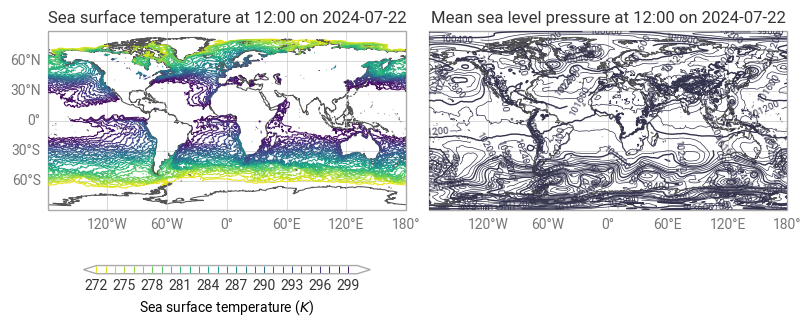

In [12]:
import earthkit.data
import earthkit.plots
import earthkit.regrid

data = earthkit.data.from_source("file", filename)
earthkit.plots.quickplot(data)